In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import scipy.signal
import warnings
# This package
import XNLdyn

%matplotlib notebook

import os
import pickle

mpl.rcParams['xtick.labelsize'] = 8 
mpl.rcParams['ytick.labelsize'] = 8 
mpl.rcParams['legend.fontsize'] = 8 
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['legend.frameon'] = False


In [18]:
load_dir = './simulation_results/07-09-2022_16-39/'
print(os.listdir(load_dir))

['save_dict.pi', 'raw_results.png', 'homogeneous_spectra.png', 'final_spectra.png', 'Input_spectrum.png']


In [19]:
with open(load_dir+'save_dict.pi','rb') as file:
    ld = pickle.load(file)
ld.keys()

dict_keys(['PAR', 'pulse_energy_max', 'N_local_fluences_to_calculate', 'load_spectrum_file', 'N_points_E', 'enax_abs', 'aufloesung', 'fl_dep_spectrum_I', 'fl_dep_spectrum_T', 'N_pulse_energies', 'final_pulse_energies', 'pulse_profile_sigma', 'Nsteps_r', 'final_incidence', 'final_incidence_peaks', 'final_transmissions'])

In [20]:
enax_abs = ld['enax_abs']
dE = enax_abs[1]-enax_abs[0]

In [21]:
aufloesung = np.sqrt((0.34/2.35)**2 + (0.48/2.35)**2) # Assuming 340 meV beamline and 4380 meV CHL, both FWHM converting to sigma


In [22]:
ld['PAR'].__dict__

{'kB': 8.617333262145e-05,
 'lightspeed': 299792458,
 'hbar': 6.582119569e-16,
 'echarge': 1.602176634e-19,
 'Nsteps_z': 25,
 'N_photens': 1,
 'N_j': 90,
 'timestep_min': 0.3,
 'Z': 20,
 'atomic_density': 91.4,
 'photon_bandwidth': 0.34,
 'temperature': 300,
 'DoS_band_origin': -10,
 'DoS_band_dd_end': 100,
 'M_core': 4,
 'R_VB_0': 10,
 'DoS_shapefile': './DoSdata_Ni_materialsproject-mp23_processed.npy',
 'tau_CH': 1.37,
 'tau_th': 6,
 'tau_free': 1.5,
 'lambda_res_Ei': (30,),
 'lambda_nonres': 940,
 'E_f': 850.5,
 'mu_chem': 0,
 'T_0': 300,
 'I0_i': 13742.103386667364,
 't0_i': [0],
 'tdur_sig_i': array([13]),
 'E_i_abs': [851.5],
 'E_i': array([1.]),
 'zstepsize': 0.8,
 'zaxis': array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2]),
 'zedges': array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 1

(848.0, 853.5)

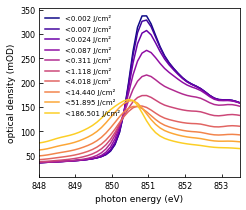

In [23]:
plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(3.5,3.))
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,ld['N_pulse_energies']))#YlOrRd_r

for i in range(ld['N_pulse_energies'])[::]:
    spec = 1e3*np.log10(ld['final_incidence'][:,i]/ld['final_transmissions'][:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec, color = plotcols[i], lw=0.5)#, label ='For one z-stack'

    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
    fluence_J = ld['final_pulse_energies'][i]
    #{fluence_J*1e9:.3f} nJ,  
    lab =  f"<{1e14*ld['final_incidence_peaks'][i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0]):.3f} J/cm²"
    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(848, 853.5)



In [24]:
# These are the pulse energies for which we evaluate stuff
set_final_pulse_energies = np.array([5.00000000e-12, 1.79690683e-11, 6.45774833e-11, 2.32079442e-10,
       8.34050269e-10, 2.99742125e-09, 1.07721735e-08, 3.87131841e-08,
       1.05e-07])#, 5.00000000e-07]
set_final_pulse_energies = np.array([4.8e-11, 2.6e-09, 10.4e-9, 3.34e-08, 0.96e-07])#,Only corresponding to experiment

#Experiment + some
set_final_pulse_energies = np.array([4.8e-11, 2.32e-10,8.34e-10, 2.6e-09, 10.4e-9, 3.34e-08, 0.96e-07])
experiment_correspondence = [True, False, False, True, True, True, True]
experiment_correspondence_ind = np.where(experiment_correspondence)[0]
N_pulse_energies = len(set_final_pulse_energies)


# # Generate a range of fluences to actually simulate from that
# fluences_simulated_joules_nm2 = np.logspace(np.log10(np.min(fluences_joules_nm2*1e-2)),
#                                  np.log10(np.max(fluences_joules_nm2)),
#                                  ld['N_local_fluences_to_calculate'])

## Load Fluences which were actually simulated 
fluences_simulated_joules_nm2 = ld['fl_dep_spectrum_I'][0]/XNLdyn.photons_per_J(ld['PAR'].E_j[0]+ld['PAR'].E_f)

In [25]:
(np.linspace(.0,0.9,len(set_final_pulse_energies)))**1.4


array([0.        , 0.07023082, 0.18534026, 0.32696218, 0.48911587,
       0.66847592, 0.86285836])

In [26]:
final_transmissions = np.zeros((ld['N_points_E'], N_pulse_energies))
final_incidence_check = np.zeros((ld['N_points_E'], N_pulse_energies))
final_incidence_peaks = np.zeros(N_pulse_energies)

for i_photen in range(ld['N_points_E']):

    for ipe, pulse_en in enumerate(set_final_pulse_energies):
        # Fluences needed to calculate this pulse energy
        local_fluences, dA = XNLdyn.calculate_fluences(ld['Nsteps_r'], pulse_en, ld['pulse_profile_sigma'])
        
        # Assert that the requested results are in the calculated range
        if not np.min(local_fluences)>np.min(fluences_simulated_joules_nm2):
            warnings.warn('Lower end of intensity extrapolated!')
        assert np.max(local_fluences)<np.max(fluences_simulated_joules_nm2)
        
        # Interpolate incident intensity
        local_incidence_check = np.interp(local_fluences, fluences_simulated_joules_nm2,
                                          ld['fl_dep_spectrum_I'][i_photen,:])
        
        
        # Interpolate transmitted intensity
        local_transmitted = np.interp(local_fluences, fluences_simulated_joules_nm2,
                                      ld['fl_dep_spectrum_T'][i_photen,:])# tr[:, 0]
        
        


        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)
        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # 
        
        final_incidence_peaks[ipe] = np.max(local_incidence_check) 
        


(2.07579080575891, 345.0)

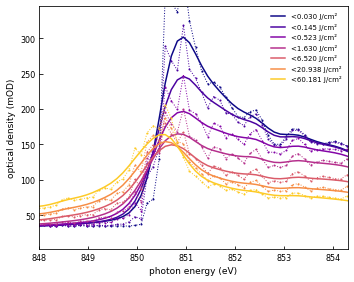

In [27]:
plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(5,4.))
#plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,len(set_final_pulse_energies)))#ld['N_pulse_energies']))#YlOrRd_r
plotcols =  mpl.cm.plasma((np.linspace(.0,0.9,len(set_final_pulse_energies)))**1.1)#YlOrRd_r

for i in range(N_pulse_energies)[::]:
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
 
    lab =  f"<{1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0]):.3f} J/cm²" 
    plt.plot(enax_abs, spec,'.:', ms=2, color = plotcols[i], lw=1)

    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(848, 854.3)
plt.ylim(None, 345)


## Quantification of effects:

* Pre-edge absorption
* Post-edge absorption
* Peak saturation
* Peak shift

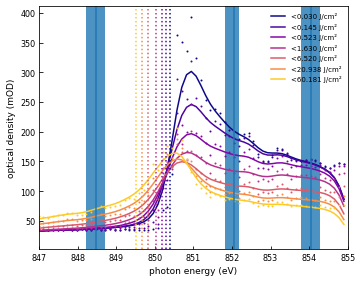

In [28]:
########### Repeat Plot
displayed_fluences = np.zeros(N_pulse_energies)

#plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,len(set_final_pulse_energies)))#YlOrRd_r
plotcols =  mpl.cm.plasma((np.linspace(.0,0.9,len(set_final_pulse_energies)))**1.1)#YlOrRd_r

plt.rcParams.update({'font.size': 9})
fig = plt.figure(figsize =(5,4.))
for i in range(N_pulse_energies)[::]:
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    #spec_sm =  sc.signal.savgol_filter(spec,9,3, mode='interp')
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'
    displayed_fluences[i]=1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0])
    lab =  f"<{displayed_fluences[i]:.3f} J/cm²" 
    
    plt.plot(enax_abs, spec,'.', ms=2, color = plotcols[i], lw=1)
    
    plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 7)
plt.xlabel('photon energy (eV)')
plt.ylabel('optical density (mOD)')
#plt.title('Spot reconstruction')
plt.tight_layout()
plt.xlim(847, 855.)

############ Draw where to quantify stuff

pre_edge_en  = 848.5
#on_edge_en   = 850.6
post_edge_en2 = 852
post_edge_en = 854
intensity_bin_width = 0.6 #eV # How wide an energy to integrate


pre_edge_index  = np.argmin(np.abs(enax_abs-pre_edge_en))
#on_edge_index   = np.argmin(np.abs(enax_abs-on_edge_en))
post_edge_index2 = np.argmin(np.abs(enax_abs-post_edge_en2))
post_edge_index = np.argmin(np.abs(enax_abs-post_edge_en))

plt.axvline(enax_abs[pre_edge_index])
#plt.axvline(enax_abs[on_edge_index])
plt.axvline(enax_abs[post_edge_index2])
plt.axvline(enax_abs[post_edge_index])

pre_edge_intensities  = np.zeros(N_pulse_energies)
on_edge_intensities   = np.zeros(N_pulse_energies)
post_edge_intensities2 = np.zeros(N_pulse_energies)
post_edge_intensities = np.zeros(N_pulse_energies)

pre_edge_intens_bin  = np.zeros(N_pulse_energies)
#on_edge_intens_bin   = np.zeros(N_pulse_energies)
post_edge_intens_bin2 = np.zeros(N_pulse_energies)
post_edge_intens_bin = np.zeros(N_pulse_energies)


############ Extract Values
peak_center_weights = np.zeros(N_pulse_energies)
peak_center_flank = np.zeros(N_pulse_energies)
flank_thresh = np.zeros(N_pulse_energies)

spectral_weight_from = 849
spectral_weight_to   = 853.5

def spectral_weight(x,y):
    return np.sum(y*x)/np.sum(y)

def find_flank(enax, spec_sm, errs = None):
    dE = enax[1]-enax[0]
    specmax = np.nanmax(spec_sm)

    if errs is not None:
        # I derive the error solely from the error of the peak height...
        maxi = np.nanargmax(spec_sm)
        specmax_err = errs[maxi]
        
    specmin = np.nanmin(spec_sm)
    #specmin = np.nanmean(spec_sm[enax<848])
    halfmax = (specmax+specmin)/2
    hmih = np.where(spec_sm>halfmax)[0][0] # index of the energy axis of the first point greater than halfmax
    hmil = hmih-1
    flank_pos = enax[hmil]+dE*(halfmax-spec_sm[hmil])/(spec_sm[hmih]-spec_sm[hmil])
    if errs is None:
        return flank_pos
    else:
        halfmax_min = (specmax-specmax_err+specmin)/2
        hmih = np.where(spec_sm>halfmax_min)[0][0] # index of the energy axis of the first point greater than halfmax
        hmil = hmih-1
        flank_pos_min = enax[hmil]+dE*(halfmax-spec_sm[hmil])/(spec_sm[hmih]-spec_sm[hmil])
        
        halfmax_max = (specmax-specmax_err+specmin)/2
        hmih = np.where(spec_sm>halfmax_min)[0][0] # index of the energy axis of the first point greater than halfmax
        hmil = hmih-1
        flank_pos_max = enax[hmil]+dE*(halfmax_max-spec_sm[hmil])/(spec_sm[hmih]-spec_sm[hmil])
        
        return flank_pos, flank_pos_max-flank_pos_min
    
def find_flank_thresh(enax, spec_sm, thresh = 110):
    dE = enax[1]-enax[0]

    specmin = np.nanmin(spec_sm)
    #specmin = np.nanmean(spec_sm[enax<848])
    
    hmih = np.where(spec_sm>thresh)[0][0] # index of the energy axis of the first point greater than halfmax
    hmil = hmih-1
    flank_pos = enax[hmil]+dE*(thresh-spec_sm[hmil])/(spec_sm[hmih]-spec_sm[hmil])
    
    return flank_pos

for i in range(N_pulse_energies)[::]:
    region = (enax_abs > spectral_weight_from) & (enax_abs < spectral_weight_to) # evaluate spectral weight in this region
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    #spec_sm =  sc.signal.savgol_filter(spec,15,3, mode='interp')
    #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)

    # Spectral weight
    peak_center_weights[i] = spectral_weight(enax_abs[region],spec_sm[region])
    peak_center_flank[i] = find_flank(enax_abs,spec_sm)
    flank_thresh[i] = find_flank_thresh(enax_abs,spec_sm)
    
    plt.axvline(peak_center_flank[i], color = plotcols[i], ls=':')
    
    pre_edge_intensities[i] = spec_sm[pre_edge_index]
    on_edge_intensities[i]  = np.max(spec_sm)#spec_sm[on_edge_index]
    post_edge_intensities[i]= spec_sm[post_edge_index]
    post_edge_intensities2[i]= spec_sm[post_edge_index2]

    pre_edge_intens_bin[i]  = np.nanmean(spec_sm[(enax_abs > (pre_edge_en-intensity_bin_width/2)) & (enax_abs < (pre_edge_en+intensity_bin_width/2))])
    #on_edge_intens_bin[i]   = np.nanmean(spec_sm[(enax_abs > (on_edge_en-intensity_bin_width/2)) & (enax_abs < (on_edge_en+intensity_bin_width/2))])
    post_edge_intens_bin[i] = np.nanmean(spec_sm[(enax_abs > (post_edge_en-intensity_bin_width/2)) & (enax_abs < (post_edge_en+intensity_bin_width/2))])
    post_edge_intens_bin2[i] = np.nanmean(spec_sm[(enax_abs > (post_edge_en2-intensity_bin_width/2)) & (enax_abs < (post_edge_en2+intensity_bin_width/2))])

    plt.axvspan(enax_abs[(enax_abs > (pre_edge_en-intensity_bin_width/2)) & (enax_abs < (pre_edge_en+intensity_bin_width/2))][0],\
                enax_abs[(enax_abs > (pre_edge_en-intensity_bin_width/2)) & (enax_abs < (pre_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    #plt.axvspan(enax_abs[(enax_abs > (on_edge_en-intensity_bin_width/2)) & (enax_abs < (on_edge_en+intensity_bin_width/2))][0],\
    #            enax_abs[(enax_abs > (on_edge_en-intensity_bin_width/2)) & (enax_abs < (on_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    plt.axvspan(enax_abs[(enax_abs > (post_edge_en-intensity_bin_width/2)) & (enax_abs < (post_edge_en+intensity_bin_width/2))][0],\
                enax_abs[(enax_abs > (post_edge_en-intensity_bin_width/2)) & (enax_abs < (post_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    plt.axvspan(enax_abs[(enax_abs > (post_edge_en2-intensity_bin_width/2)) & (enax_abs < (post_edge_en2+intensity_bin_width/2))][0],\
                enax_abs[(enax_abs > (post_edge_en2-intensity_bin_width/2)) & (enax_abs < (post_edge_en2+intensity_bin_width/2))][-1], alpha = 0.2)
    

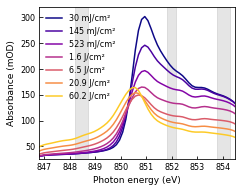

In [29]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize =(3.5,2.8))
plotcols =  mpl.cm.plasma((np.linspace(.0,0.9,len(set_final_pulse_energies)))**1.1)#YlOrRd_r

for i in range(N_pulse_energies):
    #if i in [0,3,4,5,6,7,8]:
        spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
        #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
        spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
        #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'

        fluence_Jcm2 = 1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0])
        if fluence_Jcm2<1:
            lab =  f"{fluence_Jcm2*1e3:.0f} mJ/cm²" 
        else:
            lab =  f"{fluence_Jcm2:.1f} J/cm²" 
        #plt.plot(enax_abs, spec,'.', ms=2, color = plotcols[i])

        plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab)

plt.legend(fontsize = 8, loc = 'upper left')
plt.xlabel('Photon energy (eV)', fontsize = 9)
plt.ylabel('Absorbance (mOD)', fontsize = 9)
#plt.title('Spot reconstruction')
plt.xlim(846.8, 854.5)
plt.ylim(25, 320)

for mark_energy in [pre_edge_en, post_edge_en2, post_edge_en]:
    plt.axvspan(enax_abs[(enax_abs > (mark_energy-intensity_bin_width/2)) & (enax_abs < (mark_energy+intensity_bin_width/2))][0],\
                    enax_abs[(enax_abs > (mark_energy-intensity_bin_width/2)) & (enax_abs < (mark_energy+intensity_bin_width/2))][-1], alpha = 0.2,color='gray')

plt.tick_params(labelsize = 8)

plt.tight_layout()

plt.savefig('plots/final_spectra.png', dpi=600)


## Import the experimental spectra

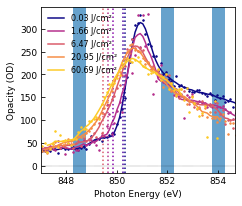

In [30]:
lde = np.load('Experimental_Spectra.npy',allow_pickle=True).item()

N_exp_fluences = len(lde['Indizes'])

exp_fluences  = np.zeros(N_exp_fluences)

exp_pre_edge_intensities  = np.zeros(N_exp_fluences)
exp_on_edge_intensities   = np.zeros(N_exp_fluences)
exp_post_edge_intensities = np.zeros(N_exp_fluences)
exp_post_edge_intensities2 = np.zeros(N_exp_fluences)
exp_pre_edge_error  = np.zeros(N_exp_fluences)
exp_on_edge_error   = np.zeros(N_exp_fluences)
exp_post_edge_error = np.zeros(N_exp_fluences)
exp_post_edge_error2 = np.zeros(N_exp_fluences)


exp_pre_edge_intens_bin  = np.zeros(N_exp_fluences)
#exp_on_edge_intens_bin   = np.zeros(N_exp_fluences)
exp_post_edge_intens_bin = np.zeros(N_exp_fluences)
exp_post_edge_intens_bin2 = np.zeros(N_exp_fluences)
exp_pre_edge_error_bin  = np.zeros(N_exp_fluences)
#exp_on_edge_error_bin   = np.zeros(N_exp_fluences)
exp_post_edge_error_bin = np.zeros(N_exp_fluences)
exp_post_edge_error_bin2 = np.zeros(N_exp_fluences)

exp_peak_center_weights = np.zeros(N_exp_fluences)
exp_peak_center_flank = np.zeros(N_exp_fluences)
exp_peak_center_flank_errs = np.zeros(N_exp_fluences)

exp_flank_thresh = np.zeros(N_exp_fluences)



N = len(lde['Indizes'])
#plotcols =  mpl.cm.plasma(np.linspace(.0,0.85,N))#YlOrRd_r


plt.figure(figsize = (3.5,3))
#ax1 = plt.subplot2grid((5,1),(0,0),rowspan = 3)
#plt.sca(ax1)
#plt.title('Spectra at different fluences')

savgol_parameters = 21,4

spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],*savgol_parameters, mode='interp')
for j,i in enumerate(lde['Indizes']):
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],*savgol_parameters, mode='interp')
    #spec_sm = sc.ndimage.gaussian_filter(lde[f'Spectrum{i}'],aufloesung/dE)
    #spec_sm = XNLdyn.reconvolve(lde['Enax'],lde[f'Spectrum{i}'],aufloesung)
    errs =  sc.signal.savgol_filter(lde[f'Error{i}'],*savgol_parameters, mode='interp')

    region = (lde['Enax'] > pre_edge_en) & (lde['Enax'] < post_edge_en) # evaluate spectral weight in this region

    exp_fluences[j] = lde[f'Fluence_mid{i}']
    exp_pre_edge_intensities[j] = np.interp(enax_abs[pre_edge_index],lde['Enax'],spec_sm)*1e3
    exp_on_edge_intensities[j] = np.nanmax(spec_sm)*1e3# np.interp(enax_abs[on_edge_index],lde['Enax'],spec_sm)*1e3
    exp_post_edge_intensities[j] = np.interp(enax_abs[post_edge_index],lde['Enax'],spec_sm)*1e3
    exp_post_edge_intensities2[j] = np.interp(enax_abs[post_edge_index2],lde['Enax'],spec_sm)*1e3

    exp_pre_edge_error[j] = np.interp(enax_abs[pre_edge_index],lde['Enax'],errs)*1e3
    exp_on_edge_error[j] = errs[np.nanargmax(spec_sm)]*1e3#np.interp(enax_abs[on_edge_index],lde['Enax'],errs)*1e3
    exp_post_edge_error[j] = np.interp(enax_abs[post_edge_index],lde['Enax'],errs)*1e3
    exp_post_edge_error2[j] = np.interp(enax_abs[post_edge_index2],lde['Enax'],errs)*1e3

    
    exp_pre_edge_intens_bin[j]  = np.nanmean(lde[f'Spectrum{i}'][(lde['Enax'] > (pre_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (pre_edge_en+intensity_bin_width/2))])*1e3
    #exp_on_edge_intens_bin[j]   = np.nanmean(lde[f'Spectrum{i}'][(lde['Enax'] > (on_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (on_edge_en+intensity_bin_width/2))])*1e3
    exp_post_edge_intens_bin[j] = np.nanmean(lde[f'Spectrum{i}'][(lde['Enax'] > (post_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en+intensity_bin_width/2))])*1e3
    exp_post_edge_intens_bin2[j] = np.nanmean(lde[f'Spectrum{i}'][(lde['Enax'] > (post_edge_en2-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en2+intensity_bin_width/2))])*1e3
    exp_pre_edge_error_bin[j]  = np.nanstd(lde[f'Spectrum{i}'][(lde['Enax'] > (pre_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (pre_edge_en+intensity_bin_width/2))])*1e3
    #exp_on_edge_error_bin[j]   = np.nanstd(lde[f'Spectrum{i}'][(lde['Enax'] > (on_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (on_edge_en+intensity_bin_width/2))])*1e3
    exp_post_edge_error_bin[j] = np.nanstd(lde[f'Spectrum{i}'][(lde['Enax'] > (post_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en+intensity_bin_width/2))])*1e3
    exp_post_edge_error_bin2[j] = np.nanstd(lde[f'Spectrum{i}'][(lde['Enax'] > (post_edge_en2-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en2+intensity_bin_width/2))])*1e3

    plt.axvspan(lde['Enax'][(lde['Enax'] > (pre_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (pre_edge_en+intensity_bin_width/2))][0],\
                lde['Enax'][(lde['Enax'] > (pre_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (pre_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    #plt.axvspan(lde['Enax'][(lde['Enax'] > (on_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (on_edge_en+intensity_bin_width/2))][0],\
    #            lde['Enax'][(lde['Enax'] > (on_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (on_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    plt.axvspan(lde['Enax'][(lde['Enax'] > (post_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en+intensity_bin_width/2))][0],\
                lde['Enax'][(lde['Enax'] > (post_edge_en-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en+intensity_bin_width/2))][-1], alpha = 0.2)
    plt.axvspan(lde['Enax'][(lde['Enax'] > (post_edge_en2-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en2+intensity_bin_width/2))][0],\
                lde['Enax'][(lde['Enax'] > (post_edge_en2-intensity_bin_width/2)) & (lde['Enax'] < (post_edge_en2+intensity_bin_width/2))][-1], alpha = 0.2)
    
    exp_peak_center_weights[j] = spectral_weight(lde['Enax'][region],spec_sm[region])
    exp_peak_center_flank[j], exp_peak_center_flank_errs[j] = find_flank(lde['Enax'],spec_sm, errs)
    exp_flank_thresh[j] = find_flank_thresh(lde['Enax'],spec_sm*1e3)
    
    plt.axvline(exp_peak_center_flank[j], color = plotcols[i], ls=':')

    plt.plot(lde['Enax'], lde[f'Spectrum{i}']*1e3,'.',ms=3,c=plotcols[experiment_correspondence_ind[j]])
    plt.plot(lde['Enax'],spec_sm*1e3,c=plotcols[experiment_correspondence_ind[j]],\
             label = f"{exp_fluences[j]:.2f} J/cm²")
    
    

    
plt.axhline(0,c='k',lw=0.4,ls=':')
plt.xlim(847,854.7)
plt.legend(fontsize = 9)
plt.tick_params(labelsize = 9)
plt.ylabel('Opacity (OD)', fontsize =9)
plt.xlabel('Photon Energy (eV)', fontsize =9)
plt.legend()
plt.tight_layout()
####################


## Effect comparison to experiment

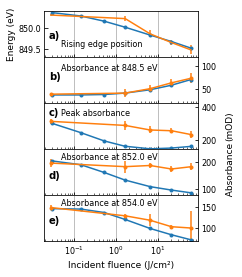

In [33]:
fig = plt.figure(figsize=(3.5,4.))
spec = fig.add_gridspec(5, 1, hspace=0)

ax0 = fig.add_subplot(spec[0, :])
plt.sca(ax0)
#plt.plot(displayed_fluences,peak_center_weights-1,'C0.:', label = 'simulation weights -1')
#plt.plot(exp_fluences,exp_peak_center_weights-1,'C1.:', label = 'experiment weights -1')
plt.plot(displayed_fluences,peak_center_flank,'C0.-', label = 'simulation')
plt.errorbar(exp_fluences,exp_peak_center_flank,exp_peak_center_flank_errs, c='C1',label = 'experiment')
#plt.plot(displayed_fluences,flank_thresh,'C0.:', label = 'flank by threshold')
#plt.plot(exp_fluences,exp_flank_thresh,'C1.:', label = 'flank by threshold')
plt.xscale('log')
plt.gca().tick_params(direction='in', which = 'both', labelsize = 8)
#plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("left")
plt.ylabel('Energy (eV)', fontsize = 9, labelpad = 2)
plt.text(0.025, 849.75,'a)', fontsize = 10, fontweight='bold')
plt.text(0.05,849.55,'Rising edge position', fontsize = 8)
plt.grid(True, axis = 'x')


ax1 = fig.add_subplot(spec[1, :])
plt.sca(ax1)

#plt.plot(displayed_fluences,pre_edge_intensities,'.-')#,label = )# label = 'simulation')
plt.plot(displayed_fluences,pre_edge_intens_bin,'C0.-')#,label = )# label = 'simulation')
#plt.errorbar(exp_fluences,exp_pre_edge_intensities,exp_pre_edge_error,marker='.')#, label = 'experiment')
plt.errorbar(exp_fluences,exp_pre_edge_intens_bin,exp_pre_edge_error_bin,marker='.',c='C1')#,label = )# label = 'simulation')
plt.xscale('log')
plt.gca().tick_params(direction='in', which = 'both', labelsize = 8)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.text(0.025, 70,'b)', fontsize = 10, fontweight='bold')
plt.text(0.05,90,'Absorbance at '+f'{pre_edge_en:.1f} eV', fontsize = 8)
plt.ylim(20, 120)
plt.grid(True, axis = 'x')


ax2 = fig.add_subplot(spec[2, :])
plt.sca(ax2)
plt.plot(displayed_fluences,on_edge_intensities,'.-')#, label = f'{on_edge_en:.1f} eV')
#plt.plot(displayed_fluences,on_edge_intens_bin,'C3.-')#, label = f'{on_edge_en:.1f} eV')
plt.errorbar(exp_fluences,exp_on_edge_intensities,exp_on_edge_error,marker='.')
#plt.errorbar(exp_fluences,exp_on_edge_intens_bin,exp_on_edge_error_bin,marker='.')
plt.xscale('log')
plt.ylabel('(mOD)', fontsize = 9, labelpad = 9)
plt.gca().tick_params(direction='in', which = 'both', labelsize = 8)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.text(0.05,350,'Peak absorbance', fontsize = 8)
plt.text(0.025, 350,'c)', fontsize = 10, fontweight='bold')
plt.ylim(150, 425)
plt.grid(True, axis = 'x')

#plt.legend(loc='lower left')



ax3 = fig.add_subplot(spec[3, :])
plt.sca(ax3)
#plt.plot(displayed_fluences,post_edge_intensities2,'C0.-', label = f'{post_edge_en2:.1f} eV')
plt.plot(displayed_fluences,post_edge_intens_bin2,'C0.-', label = f'{post_edge_en2:.1f} eV')
#plt.errorbar(exp_fluences,exp_post_edge_intensities2,exp_post_edge_error2, c='C1',marker='.', ls='-')#, label = f'{post_edge_en2:.0f} eV'
plt.errorbar(exp_fluences,exp_post_edge_intens_bin2,exp_post_edge_error_bin2, c='C1',marker='.', ls='-')#, label = f'{post_edge_en2:.0f} eV'
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.xscale('log')
plt.ylabel('  Absorbance', fontsize = 9, labelpad = 10)
plt.gca().tick_params(direction='in', which = 'both', labelsize = 8)
plt.text(0.025, 140,'d)', fontsize = 10, fontweight='bold')
plt.text(0.05,210,'Absorbance at '+f'{post_edge_en2:.1f} eV', fontsize = 8)
plt.yticks([100,200])
plt.ylim(80, 250)
plt.grid(True, axis = 'x')

ax4 = fig.add_subplot(spec[4, :])
plt.sca(ax4)
plt.ylim(70, 180)
#plt.plot(displayed_fluences,post_edge_intensities,'C0.-',  label = f'{post_edge_en:.1f} eV')
plt.plot(displayed_fluences,post_edge_intens_bin,'C0.-',  label = f'{post_edge_en:.1f} eV')
#plt.errorbar(exp_fluences,exp_post_edge_intensities,exp_post_edge_error, c='C1',marker='.')# 
plt.errorbar(exp_fluences,exp_post_edge_intens_bin,exp_post_edge_error_bin, c='C1',marker='.')# 
plt.xscale('log')
#plt.ylabel('mOD')
plt.gca().tick_params(direction='in', which = 'both', labelsize = 8)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.text(0.025, 110,'e)', fontsize = 10, fontweight='bold')
plt.text(0.05,155,'Absorbance at '+f'{post_edge_en:.1f} eV', fontsize = 8)
plt.grid(True, axis = 'x')
#plt.legend(loc='lower left')
plt.xlabel('Incident fluence (J/cm²)', fontsize = 9)

plt.tight_layout()
plt.savefig('./plots/parameter_comparison.png', dpi=600)


# Comparing the derivative

(848.0, 854.0)

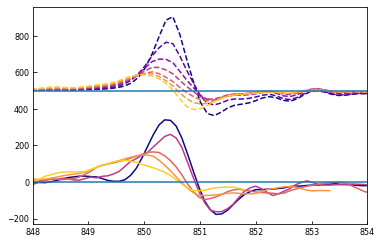

In [32]:
offset=500

#plotcols =  mpl.cm.plasma(np.linspace(.0,0.85,N))#YlOrRd_r
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,len(set_final_pulse_energies)))#YlOrRd_r

plt.figure()
spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],21,4, mode='interp')
for j,i in enumerate(lde['Indizes']):
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],21,4, mode='interp')*1e3
    enax = lde['Enax']
    dE = enax[1]-enax[0]
    enax_mids = (enax[1:]+enax[:-1])/2

    flank_pos = find_flank(enax, spec_sm)
    #plt.axvline(flank_pos, color = plotcols[i])
    
    spec_diff = np.diff(spec_sm, n=1)/dE
    spec_diff_sm = sc.signal.savgol_filter(spec_diff,15,4, mode='interp')
    #errs =  sc.signal.savgol_filter(lde[f'Error{i}'],15,3, mode='interp')

    exp_peak_center_weights[j] = spectral_weight(enax[region],spec_sm[region])

    
    #plt.plot(lde['Enax'], lde[f'Spectrum{i}'],'.',ms=3,c=plotcols[j])
    #plt.plot(enax_mids,spec_diff,c=plotcols[j],lw=0.5)
    plt.plot(enax_mids,spec_diff_sm,c=plotcols[experiment_correspondence_ind[j]],\
             label = f"{exp_fluences[j]:.2f} J/cm²")
plt.axhline()
plt.xlim(848,854)
plotcols =  mpl.cm.plasma(np.linspace(.0,0.9,len(set_final_pulse_energies)))#YlOrRd_r

#plt.figure()
for i in range(N_pulse_energies)[::]:
    spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
    enax_mids = (enax_abs[1:]+enax_abs[:-1])/2 
    
    dE = enax_abs[1]-enax_abs[0]
    spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
    
    
    flank_pos = find_flank(enax_abs, spec_sm)
    #plt.axvline(flank_pos, color = plotcols[i])
    
    
    spec_diff = np.diff(spec_sm, n=1)/dE
    
    
    displayed_fluences[i]=1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0])
    
    lab =  f"<{displayed_fluences[i]:.3f} J/cm²" 
    
    
    plt.plot(enax_mids, offset+spec_diff, color = plotcols[i], label =lab, ls = '--')
plt.axhline(offset)
plt.xlim(848,854)

In [17]:
aufloesung = np.sqrt((0.34/2.35)**2 + (0.48/2.35)**2) # Assuming 340 meV beamline and 4380 meV CHL, both FWHM converting to sigma


# Pretty plot of Experiment

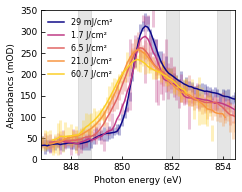

In [20]:

plt.figure(figsize = (3.5,2.8))

for mark_energy in [pre_edge_en, post_edge_en2, post_edge_en]:
    plt.axvspan(lde['Enax'][(lde['Enax'] > (mark_energy-intensity_bin_width/2)) & (lde['Enax'] < (mark_energy+intensity_bin_width/2))][0],\
                    lde['Enax'][(lde['Enax'] > (mark_energy-intensity_bin_width/2)) & (lde['Enax'] < (mark_energy+intensity_bin_width/2))][-1], alpha = 0.2,color='gray')
    
spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],*savgol_parameters, mode='interp')
for j,i in enumerate(lde['Indizes']):
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],*savgol_parameters, mode='interp')
    errs =  sc.signal.savgol_filter(lde[f'Error{i}'],*savgol_parameters, mode='interp')

    fluence_Jcm2 = exp_fluences[j]
    if fluence_Jcm2<1:
        lab =  f"{fluence_Jcm2*1e3:.0f} mJ/cm²" 
    else:
        lab =  f"{fluence_Jcm2:.1f} J/cm²" 
    #lab = f"{exp_fluences[j]:.2f} J/cm²"
    

    plt.errorbar(lde['Enax'],lde[f'Spectrum{i}']*1e3,lde[f'Error{i}']*1e3,color = plotcols[experiment_correspondence_ind[j]],\
                 ls ='', alpha = 0.3, elinewidth = 3)#, marker = '.'
    plt.plot(lde['Enax'], spec_sm*1e3,c=plotcols[experiment_correspondence_ind[j]], label = lab)

plt.ylabel('Absorbancs (mOD)', fontsize = 9)
plt.xlabel('Photon energy (eV)', fontsize = 9)
plt.legend(fontsize = 8)
plt.tick_params(labelsize = 9)
plt.ylim(0,350)
plt.xlim(846.8, 854.5)
plt.tight_layout()


plt.savefig('./plots/experiment_spectra.png', dpi=600)


# Combined Paper plot

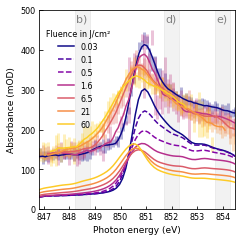

In [21]:
fig = plt.figure(figsize = (3.5,3.5))
offset = 100
#ax1 = plt.subplot(2,1,1)

#######
## Experiment
#######

# for mark_energy in [pre_edge_en, post_edge_en2, post_edge_en]:
#     plt.axvspan(lde['Enax'][(lde['Enax'] > (mark_energy-intensity_bin_width/2)) & (lde['Enax'] < (mark_energy+intensity_bin_width/2))][0],\
#                     lde['Enax'][(lde['Enax'] > (mark_energy-intensity_bin_width/2)) & (lde['Enax'] < (mark_energy+intensity_bin_width/2))][-1], alpha = 0.2,color='gray')
    
#plt.plot([np.nan], [np.nan], label = 'Fluence (J/cm²)', linestyle = '')
spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],*savgol_parameters, mode='interp')
for j,i in enumerate(lde['Indizes']):
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],*savgol_parameters, mode='interp')
    errs =  sc.signal.savgol_filter(lde[f'Error{i}'],*savgol_parameters, mode='interp')

    fluence_Jcm2 = exp_fluences[j]
    if fluence_Jcm2<1:
        lab =  f"{fluence_Jcm2*1e3:.0f} mJ/cm²" 
    else:
        lab =  f"{fluence_Jcm2:.1f} J/cm²" 
    #lab = f"{exp_fluences[j]:.2f} J/cm²"
    lab = None

    plt.errorbar(lde['Enax'],offset+lde[f'Spectrum{i}']*1e3,lde[f'Error{i}']*1e3,color = plotcols[experiment_correspondence_ind[j]],\
                 ls ='', alpha = 0.3, elinewidth = 3)#, marker = '.'
    plt.plot(lde['Enax'],offset+ spec_sm*1e3,c=plotcols[experiment_correspondence_ind[j]], label = lab)



#################################
#ax2 = plt.subplot(2,1,2, sharex = ax1)
#####################################

plotcols =  mpl.cm.plasma((np.linspace(.0,0.9,len(set_final_pulse_energies)))**1.1)#YlOrRd_r

for i in range(N_pulse_energies):
    #if i in [0,3,4,5,6,7,8]:
        spec = 1e3*np.log10(final_incidence_check[:,i]/final_transmissions[:,i])
        #spec_sm = sc.ndimage.gaussian_filter(spec,aufloesung/dE)
        spec_sm = XNLdyn.reconvolve(enax_abs,spec,aufloesung)
        #plt.plot(enax_abs, spec_sm, color = plotcols[i], label = f'{final_pulse_energies[i]*1e6:.2f} µJ')#, label ='For one z-stack'

        fluence_Jcm2 = 1e14*final_incidence_peaks[i]/XNLdyn.photons_per_J(ld['PAR'].E_i_abs[0])
        if fluence_Jcm2<.1:
            lab =  f"{fluence_Jcm2:.2f}" 
        elif fluence_Jcm2<10:
            lab =  f"{fluence_Jcm2:.1f}" 
        else:            
            lab =  f"{fluence_Jcm2:.0f}" 

        #plt.plot(enax_abs, spec,'.', ms=2, color = plotcols[i])
        
        linestyle = '-'
        if i in [1,2]:
            linestyle = '--'
        plt.plot(enax_abs, spec_sm, color = plotcols[i], label =lab, ls=linestyle)



for mark_energy in [pre_edge_en, post_edge_en2, post_edge_en]:
    plt.axvspan(mark_energy-intensity_bin_width/2, mark_energy+intensity_bin_width/2,\
                alpha = 0.1,color='gray')

#plt.text(849, 230, 'a)')            
#plt.arrow(850.3, 225, -0.9, 30, width = 0.07, head_width = 0.35,head_length = 5,
#          zorder = 10,length_includes_head=True, shape = 'left')

plt.text(pre_edge_en-0.23, 470, 'b)', color = 'gray')

#plt.text(850.7, 440, 'c)')
#plt.arrow(850.65, 430, -0.6, -100, width = 0.05, head_width = 0.2,head_length = 20,
#          zorder = 10,length_includes_head=True, shape = 'left')
plt.text(post_edge_en2-0.23, 470, 'd)', color = 'gray')
plt.text(post_edge_en-0.23, 470, 'e)', color = 'gray')


legend = plt.legend(fontsize = 8, loc = 'upper left', title ='Fluence in J/cm²',bbox_to_anchor=(0.0, 0., 0, 0.94),frameon= False)
plt.setp(legend.get_title(),fontsize=8)

plt.xlabel('Photon energy (eV)', fontsize = 9)
plt.ylabel('Absorbance (mOD)', fontsize = 9)
#plt.title('Spot reconstruction')
plt.xlim(846.8, 854.5)
plt.ylim(0,500)
plt.yticks([0,100,200,300,400,500])
#plt.subplots_adjust(hspace=0)
plt.tight_layout()

plt.savefig('./plots/combined_spectra.png', dpi=600)


## Total spectral redshift

In [22]:
exp_peak_center_flank[0] - exp_peak_center_flank[-1]

0.849818918153801

## Error of Total spectral redshift

In [23]:
np.sqrt(exp_peak_center_flank_errs[0]**2 + exp_peak_center_flank_errs[-1]**2)

0.11538267527011091

In [24]:
# What is the mean free flight duration of an 850eV electron in nickel
m_e = 9.1e-31 #kg
e = 1.6e-19 #C
E = 850*e
v_e=np.sqrt(E/m_e)#*1e9*1e15 # nm/fs
lb=1.3e-9 #inelastic mean free path (NIST database)
1e18*lb/v_e # time in attoseconds

106.33949518073761

In [25]:
# Applying the power law for the shift in PHYSICAL REVIEW B 103, 064305 (2021) to our temperature oes not work...
c = 0.2/5200**1.5
c*40/ld['PAR'].kB**1.5

26.670161044074504

## Different plotting for Loics report

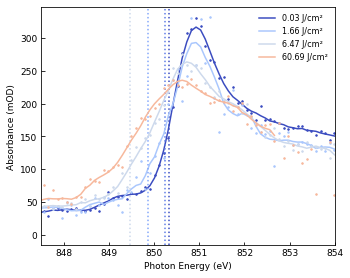

In [26]:
lde = np.load('Experimental_Spectra.npy',allow_pickle=True).item()

N_exp_fluences = len(lde['Indizes'])

plotcols =  mpl.cm.coolwarm(np.linspace(.0,1,ld['N_pulse_energies']))#YlOrRd_r

N = len(lde['Indizes'])
#plotcols =  mpl.cm.plasma(np.linspace(.0,0.85,N))#YlOrRd_r


plt.figure(figsize = (5,4))
#ax1 = plt.subplot2grid((5,1),(0,0),rowspan = 3)
#plt.sca(ax1)
#plt.title('Spectra at different fluences')

savgol_parameters = 19,4

spec1 = sc.signal.savgol_filter(lde[f'Spectrum{0}'],*savgol_parameters, mode='interp')
for j,i in enumerate(lde['Indizes']):
    if j == 3:
        continue
    spec_sm =  sc.signal.savgol_filter(lde[f'Spectrum{i}'],*savgol_parameters, mode='interp')
    #spec_sm = sc.ndimage.gaussian_filter(lde[f'Spectrum{i}'],aufloesung/dE)
    #spec_sm = XNLdyn.reconvolve(lde['Enax'],lde[f'Spectrum{i}'],aufloesung)
    errs =  sc.signal.savgol_filter(lde[f'Error{i}'],*savgol_parameters, mode='interp')
    exp_fluences[j] = lde[f'Fluence_mid{i}']

    region = (lde['Enax'] > pre_edge_en) & (lde['Enax'] < post_edge_en) # evaluate spectral weight in this region

    
    plt.axvline(exp_peak_center_flank[j], color = plotcols[i], ls=':')

    plt.plot(lde['Enax'], lde[f'Spectrum{i}']*1e3,'.',ms=3,c=plotcols[experiment_correspondence_ind[j]])
    plt.plot(lde['Enax'],spec_sm*1e3,c=plotcols[experiment_correspondence_ind[j]],\
             label = f"{exp_fluences[j]:.2f} J/cm²")
    
    

    
#plt.axhline(0,c='k',lw=0.4,ls=':')
plt.xlim(847.5,854.)
plt.legend(fontsize = 9)
plt.tick_params(labelsize = 9)
plt.ylabel('Absorbance (mOD)', fontsize =9)
plt.xlabel('Photon Energy (eV)', fontsize =9)
plt.legend()
plt.tight_layout()
plt.gca().tick_params(direction = 'in', which = 'both')
####################
plt.savefig('./plots/experiment_spectra_varied.pdf', dpi=600)
